# Options

In [1]:
options(stringAsFactor = FALSE)

# Libraries

In [2]:
library("dorothea")
library(eulerr)

# Variables

In [3]:
cell_lines <- c("Ly1"
               ,"Ly8")

In [4]:
threshold_padj <- 0.1

In [5]:
threshold_absLcf2 <- 1

# Load data

In [6]:
## We read Dorothea Regulons for Human:
dorothea_hs <- get(data("dorothea_hs", package = "dorothea"))
print(str(dorothea_hs))

tibble [454,504 × 4] (S3: tbl_df/tbl/data.frame)
 $ tf        : chr [1:454504] "ADNP" "ADNP" "ADNP" "ADNP" ...
 $ confidence: chr [1:454504] "D" "D" "D" "D" ...
 $ target    : chr [1:454504] "ATF7IP" "DYRK1A" "TLK1" "ZMYM4" ...
 $ mor       : num [1:454504] 1 1 1 1 1 1 1 1 1 1 ...
NULL


In [7]:
genes <- read.csv("TableS7_de_genes.txt"
                     ,sep = "\t"
                     ,header = TRUE)
print(str(genes))

'data.frame':	24649 obs. of  8 variables:
 $ baseMean      : num  1205.8 58.3 77.4 64.6 63.4 ...
 $ log2FoldChange: num  0.0262 0.315 0.2661 -0.2628 -0.1089 ...
 $ lfcSE         : num  0.0749 0.2399 0.2186 0.2027 0.2005 ...
 $ stat          : num  0.35 1.313 1.217 -1.296 -0.543 ...
 $ pvalue        : num  0.726 0.189 0.224 0.195 0.587 ...
 $ padj          : num  0.876 0.429 0.474 0.436 0.79 ...
 $ gene_name     : chr  "DPM1" "C1orf112" "GCLC" "NFYA" ...
 $ cell_line     : chr  "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" ...
NULL


# Process data

## Hypothesis 1: FAS-regulating TF are affected

In [8]:
# subset the TF DB to FAS only
dorothea_hs <- as.data.frame(dorothea_hs)
idx_fas <- dorothea_hs$target == "FAS"
print(paste("we have "
           ,sum(idx_fas)
           ," TF that target FAS in the dorothea DB"))
tf_fas <- dorothea_hs[idx_fas,]
rownames(tf_fas) <- tf_fas$tf
print(tf_fas)

[1] "we have  61  TF that target FAS in the dorothea DB"
             tf confidence target mor
AEBP2     AEBP2          E    FAS   1
AIRE       AIRE          E    FAS   1
ARID5A   ARID5A          E    FAS  -1
ARNTL2   ARNTL2          E    FAS   1
BARHL1   BARHL1          E    FAS   1
BARX1     BARX1          E    FAS   1
BHLHE41 BHLHE41          E    FAS  -1
BSX         BSX          E    FAS   1
CEBPA     CEBPA          A    FAS   1
DLX3       DLX3          E    FAS   1
EGR1       EGR1          A    FAS  -1
EGR2       EGR2          D    FAS   1
EN1         EN1          E    FAS   1
ETS1       ETS1          A    FAS   1
ETV7       ETV7          E    FAS  -1
FOS         FOS          A    FAS   1
FOXC1     FOXC1          E    FAS   1
GBX1       GBX1          E    FAS   1
GBX2       GBX2          E    FAS   1
GLI1       GLI1          D    FAS  -1
GLI2       GLI2          A    FAS  -1
GLIS3     GLIS3          E    FAS   1
HDX         HDX          E    FAS   1
HOXB3     HOXB3          E    F

In [9]:
# which FAS-regulating TF are differential
tf_fas_diff <- lapply(cell_lines
                          ,function(cell_line){
                              idx_cell_line  <-  genes$cell_line == paste0("OCI-",cell_line)
                              my_de <- genes[idx_cell_line,]

                              idx_padj <- my_de$padj < threshold_padj
                              idx_lfc2 <- abs(my_de$log2FoldChange) > threshold_absLcf2

                              rownames(my_de) <- my_de$gene_name

                              my_de <- my_de[idx_padj & idx_lfc2,]
                              
                              # subset to FAS-regulating only
                              my_de <- my_de[my_de$gene_name %in% rownames(tf_fas),]
                              my_de
                              
                          })
names(tf_fas_diff) <- cell_lines
print(tf_fas_diff)

$Ly1
        baseMean log2FoldChange     lfcSE      stat       pvalue         padj
ARNTL2  10.05199      -3.077848 0.5805596 -5.301520 1.148425e-07 4.566109e-06
FOXC1   37.11209       1.957812 0.3518550  5.564259 2.632685e-08 1.279360e-06
SP140  174.32195      -1.241932 0.3099671 -4.006658 6.158405e-05 1.008233e-03
STAT1  212.41088       1.415949 0.5464256  2.591292 9.561624e-03 5.640253e-02
MSX1    11.17891       1.437268 0.5233789  2.746132 6.030243e-03 4.061956e-02
TSHZ2   19.27763       2.380492 0.7573771  3.143074 1.671836e-03 1.516541e-02
       gene_name cell_line
ARNTL2    ARNTL2   OCI-Ly1
FOXC1      FOXC1   OCI-Ly1
SP140      SP140   OCI-Ly1
STAT1      STAT1   OCI-Ly1
MSX1        MSX1   OCI-Ly1
TSHZ2      TSHZ2   OCI-Ly1

$Ly8
       baseMean log2FoldChange     lfcSE      stat       pvalue         padj
ARID5A  64.9485      -1.294326 0.2614632 -4.950318 7.409245e-07 6.154149e-05
       gene_name cell_line
ARID5A    ARID5A   OCI-Ly8



character(0)


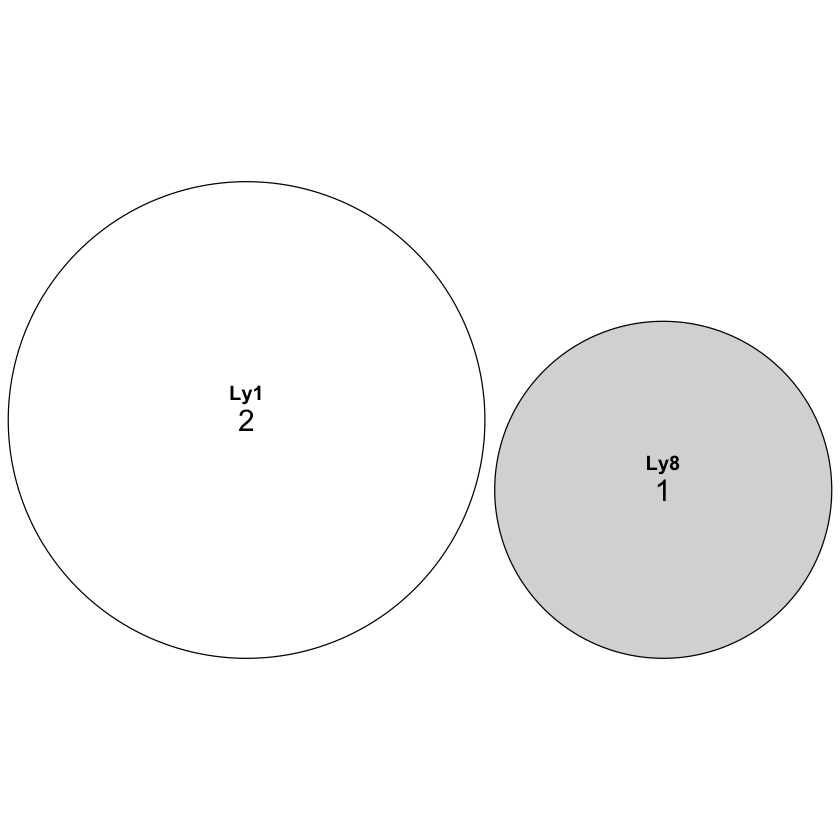

In [10]:
# plot overlap between Ly1 and Ly8 down
idx_down_ly1 <- tf_fas_diff$Ly1$log2FoldChange < -threshold_absLcf2
idx_down_ly8 <- tf_fas_diff$Ly8$log2FoldChange < -threshold_absLcf2
plot(euler(list(Ly1 = rownames(tf_fas_diff$Ly1[idx_down_ly1,])
               ,Ly8 = rownames(tf_fas_diff$Ly8[idx_down_ly8,])
               )
          )
    ,quantities = list(fontsize = 18)
    ,counts = T
    )

print(intersect(rownames(tf_fas_diff$Ly1[idx_down_ly1,])
               ,rownames(tf_fas_diff$Ly8[idx_down_ly8,])) )

character(0)


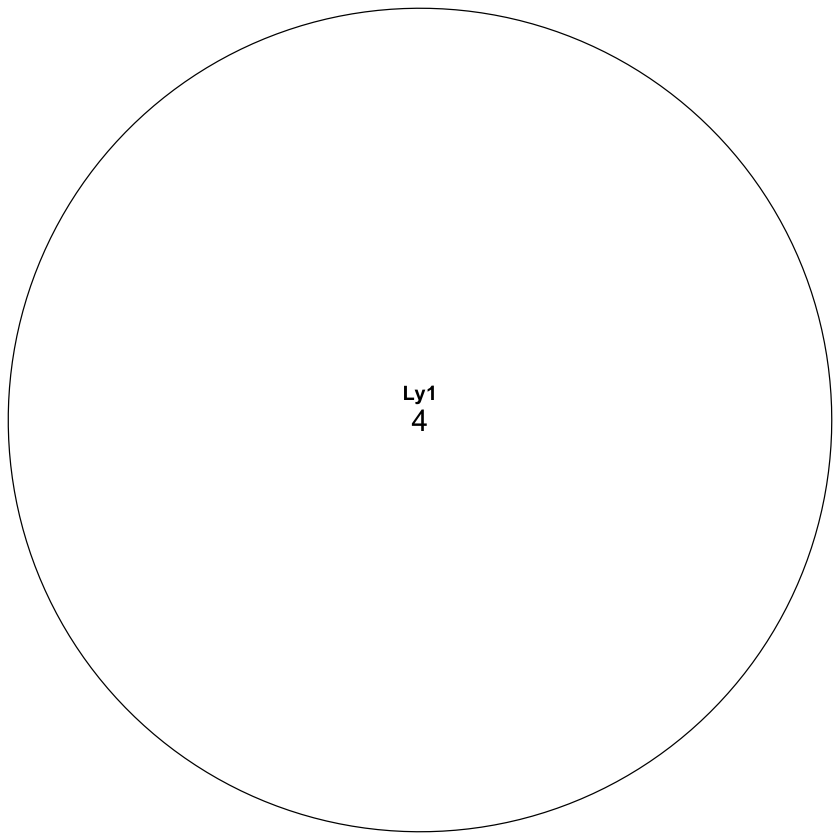

In [11]:
# plot overlap between Ly1 and Ly8 up
idx_up_ly1 <- tf_fas_diff$Ly1$log2FoldChange > threshold_absLcf2
idx_up_ly8 <- tf_fas_diff$Ly8$log2FoldChange > threshold_absLcf2
plot(euler(list(Ly1 = rownames(tf_fas_diff$Ly1[idx_up_ly1,])
               ,Ly8 = rownames(tf_fas_diff$Ly8[idx_up_ly8,]))
          )
    ,quantities = list(fontsize = 18)
    ,counts = T
    )

print(intersect(rownames(tf_fas_diff$Ly1[idx_up_ly1,])
               ,rownames(tf_fas_diff$Ly8[idx_up_ly8,])) )

## Hypothesis 2: FAS-regulating co-TF are affected

### Expressed but not differential FAS-regulating TF

In [12]:
# which tf for fas are expressed in our data
tf_fas_expressed <- lapply(cell_lines
                          ,function(cell_line){
                              idx_cell_line  <-  genes$cell_line == paste0("OCI-",cell_line)
                              idx_present <- tf_fas$tf %in% genes$gene_name[idx_cell_line]
                              
                              print(paste0(cell_line
                                          ," expresses "
                                          ,sum(idx_present)
                                          ," tf for fas"))
                              
                              tf_fas[idx_present,]
                          })
names(tf_fas_expressed) <- cell_lines
print(tf_fas_expressed)

[1] "Ly1 expresses 27 tf for fas"
[1] "Ly8 expresses 27 tf for fas"
$Ly1
           tf confidence target mor
AEBP2   AEBP2          E    FAS   1
ARID5A ARID5A          E    FAS  -1
ARNTL2 ARNTL2          E    FAS   1
ETS1     ETS1          A    FAS   1
FOXC1   FOXC1          E    FAS   1
MSX1     MSX1          E    FAS  -1
MYBL1   MYBL1          E    FAS   1
NFKB1   NFKB1          A    FAS   1
NFYC     NFYC          D    FAS   1
PURA     PURA          E    FAS  -1
SHOX2   SHOX2          E    FAS   1
SOX4     SOX4          E    FAS   1
SP1       SP1          A    FAS   1
SP100   SP100          E    FAS   1
SP110   SP110          E    FAS   1
SP140   SP140          E    FAS   1
SP140L SP140L          E    FAS   1
STAT1   STAT1          A    FAS   1
STAT3   STAT3          A    FAS  -1
TP53     TP53          A    FAS   1
TSHZ2   TSHZ2          E    FAS   1
YBX1     YBX1          D    FAS  -1
YY1       YY1          A    FAS  -1
ZBTB21 ZBTB21          E    FAS   1
ZNF136 ZNF136          E   

In [13]:
# which of them are expressed, but not differential
tf_fas_expressed_notDiff <- lapply(cell_lines
                          ,function(cell_line){
                              idx_cell_line  <-  genes$cell_line == paste0("OCI-",cell_line)
                              idx_present <- tf_fas$tf %in% genes$gene_name[idx_cell_line]
                              idx_diff <- tf_fas$tf %in% tf_fas_diff[[cell_line]]$gene_name
                              
                              print(paste0(cell_line
                                          ," expresses "
                                          ,sum(idx_present & !idx_diff)
                                          ," non-differential tf for fas"))
                              
                              tf_fas[idx_present & !idx_diff,]
                          })
names(tf_fas_expressed_notDiff) <- cell_lines
print(tf_fas_expressed_notDiff)

[1] "Ly1 expresses 21 non-differential tf for fas"
[1] "Ly8 expresses 26 non-differential tf for fas"
$Ly1
           tf confidence target mor
AEBP2   AEBP2          E    FAS   1
ARID5A ARID5A          E    FAS  -1
ETS1     ETS1          A    FAS   1
MYBL1   MYBL1          E    FAS   1
NFKB1   NFKB1          A    FAS   1
NFYC     NFYC          D    FAS   1
PURA     PURA          E    FAS  -1
SHOX2   SHOX2          E    FAS   1
SOX4     SOX4          E    FAS   1
SP1       SP1          A    FAS   1
SP100   SP100          E    FAS   1
SP110   SP110          E    FAS   1
SP140L SP140L          E    FAS   1
STAT3   STAT3          A    FAS  -1
TP53     TP53          A    FAS   1
YBX1     YBX1          D    FAS  -1
YY1       YY1          A    FAS  -1
ZBTB21 ZBTB21          E    FAS   1
ZNF136 ZNF136          E    FAS   1
ZNF140 ZNF140          E    FAS   1
ZNF267 ZNF267          E    FAS   1

$Ly8
           tf confidence target mor
AEBP2   AEBP2          E    FAS   1
ARNTL2 ARNTL2          

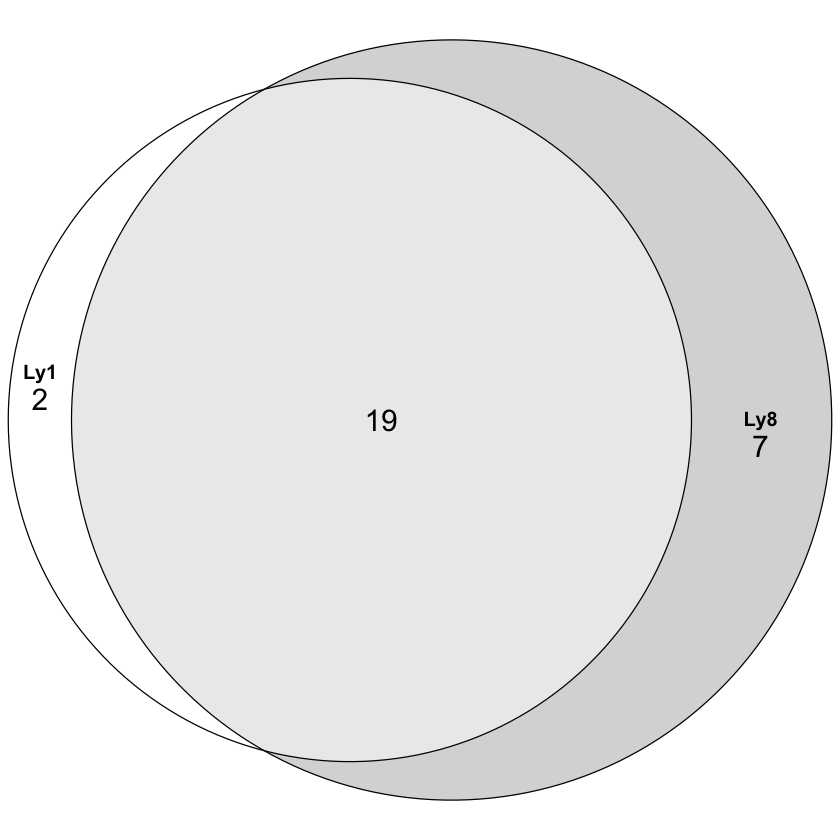

In [14]:
# plot overlap between Ly1 and Ly8
plot(euler(list(Ly1 = rownames(tf_fas_expressed_notDiff$Ly1)
               ,Ly8 = rownames(tf_fas_expressed_notDiff$Ly8))
          )
    ,quantities = list(fontsize = 18)
    ,counts = T
    )

In [15]:
pdf("FAS_TF_expressed_not_diff.pdf")
plot(euler(list(Ly1 = rownames(tf_fas_expressed_notDiff$Ly1)
               ,Ly8 = rownames(tf_fas_expressed_notDiff$Ly8))
          )
    ,quantities = list(fontsize = 18)
    ,counts = T
    )
dev.off()

pdf 
  2

### Differential TF wich are not FAS-regulators (i.e. potential coTF)

In [16]:
# subset DE genes to TF only
genes_TF <- lapply(cell_lines
               ,function(cell_line){
                print(cell_line)
                
                idx_cell_line  <-  genes$cell_line == paste0("OCI-",cell_line)
                my_de <- genes[idx_cell_line,]
                
                my_de <- my_de[my_de$gene_name %in% dorothea_hs$tf,]
                my_de
            })
names(genes_TF) <- cell_lines
print(str(genes_TF))

[1] "Ly1"
[1] "Ly8"
List of 2
 $ Ly1:'data.frame':	665 obs. of  8 variables:
  ..$ baseMean      : num [1:665] 64.6 186.7 78 90.6 14.7 ...
  ..$ log2FoldChange: num [1:665] -0.2628 0.3139 -0.1055 -0.0456 0.7769 ...
  ..$ lfcSE         : num [1:665] 0.203 0.237 0.21 0.169 0.436 ...
  ..$ stat          : num [1:665] -1.296 1.324 -0.503 -0.27 1.783 ...
  ..$ pvalue        : num [1:665] 0.1949 0.1857 0.6152 0.7874 0.0746 ...
  ..$ padj          : num [1:665] 0.436 0.424 0.809 0.905 0.237 ...
  ..$ gene_name     : chr [1:665] "NFYA" "ZNF195" "ZFX" "ZNF263" ...
  ..$ cell_line     : chr [1:665] "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" ...
 $ Ly8:'data.frame':	672 obs. of  8 variables:
  ..$ baseMean      : num [1:672] 63 447.8 79.5 78.8 136.7 ...
  ..$ log2FoldChange: num [1:672] 0.0349 0.2265 -0.0387 0.0525 -0.2409 ...
  ..$ lfcSE         : num [1:672] 0.257 0.146 0.222 0.225 0.268 ...
  ..$ stat          : num [1:672] 0.136 1.554 -0.174 0.233 -0.897 ...
  ..$ pvalue        : num [1:672] 0.8

In [17]:
# which of them are significant
genes_TF_sign <- lapply(cell_lines
                  ,function(cell_line){
                
    my_de <- genes_TF[[cell_line]]
    
    idx_padj <- my_de$padj < threshold_padj
    idx_lfc2 <- abs(my_de$log2FoldChange) > threshold_absLcf2
                      
    rownames(my_de) <- my_de$gene_name
    print(head(rownames(my_de)))
    
    my_de[idx_padj & idx_lfc2,]
    
                  }
                 )
names(genes_TF_sign) <- cell_lines
print(str(genes_TF_sign))

[1] "NFYA"   "ZNF195" "ZFX"    "ZNF263" "PAX6"   "E2F2"  
[1] "NFYA"   "ZNF195" "ZFX"    "ZNF263" "E2F2"   "NFIX"  
List of 2
 $ Ly1:'data.frame':	51 obs. of  8 variables:
  ..$ baseMean      : num [1:51] 141.1 10.1 37.1 23.6 19.9 ...
  ..$ log2FoldChange: num [1:51] -1.16 -3.08 1.96 -1.22 2.57 ...
  ..$ lfcSE         : num [1:51] 0.249 0.581 0.352 0.362 0.495 ...
  ..$ stat          : num [1:51] -4.67 -5.3 5.56 -3.37 5.2 ...
  ..$ pvalue        : num [1:51] 3.03e-06 1.15e-07 2.63e-08 7.55e-04 1.96e-07 ...
  ..$ padj          : num [1:51] 7.86e-05 4.57e-06 1.28e-06 7.96e-03 7.24e-06 ...
  ..$ gene_name     : chr [1:51] "RUNX3" "ARNTL2" "FOXC1" "ZFAT" ...
  ..$ cell_line     : chr [1:51] "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" ...
 $ Ly8:'data.frame':	29 obs. of  8 variables:
  ..$ baseMean      : num [1:29] 21.1 40.5 22.4 21.5 151.4 ...
  ..$ log2FoldChange: num [1:29] 1.74 -2.14 -2.24 1.28 -1.33 ...
  ..$ lfcSE         : num [1:29] 0.493 0.367 0.56 0.452 0.222 ...
  ..$ stat          

In [18]:
# exclude FAS-regultaing
genes_TF_sign_notFASreg <- lapply(cell_lines
                    ,function(cell_line){
                        my_de_sign <- genes_TF_sign[[cell_line]]
                        
                        my_de_sign[!(my_de_sign$gene_name %in% tf_fas$tf),]
                    })
names(genes_TF_sign_notFASreg) <- cell_lines
print(str(genes_TF_sign_notFASreg))

List of 2
 $ Ly1:'data.frame':	45 obs. of  8 variables:
  ..$ baseMean      : num [1:45] 141.1 23.6 19.9 449.7 328 ...
  ..$ log2FoldChange: num [1:45] -1.16 -1.22 2.57 1.2 1.21 ...
  ..$ lfcSE         : num [1:45] 0.249 0.362 0.495 0.402 0.174 ...
  ..$ stat          : num [1:45] -4.67 -3.37 5.2 2.97 6.97 ...
  ..$ pvalue        : num [1:45] 3.03e-06 7.55e-04 1.96e-07 2.98e-03 3.17e-12 ...
  ..$ padj          : num [1:45] 7.86e-05 7.96e-03 7.24e-06 2.35e-02 3.73e-10 ...
  ..$ gene_name     : chr [1:45] "RUNX3" "ZFAT" "ZFY" "MEF2A" ...
  ..$ cell_line     : chr [1:45] "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" ...
 $ Ly8:'data.frame':	28 obs. of  8 variables:
  ..$ baseMean      : num [1:28] 21.1 40.5 22.4 21.5 151.4 ...
  ..$ log2FoldChange: num [1:28] 1.74 -2.14 -2.24 1.28 -1.33 ...
  ..$ lfcSE         : num [1:28] 0.493 0.367 0.56 0.452 0.222 ...
  ..$ stat          : num [1:28] 3.53 -5.82 -4.01 2.83 -5.96 ...
  ..$ pvalue        : num [1:28] 4.15e-04 5.80e-09 6.15e-05 4.63e-03 2.52e-0

[1] "RUNX3"


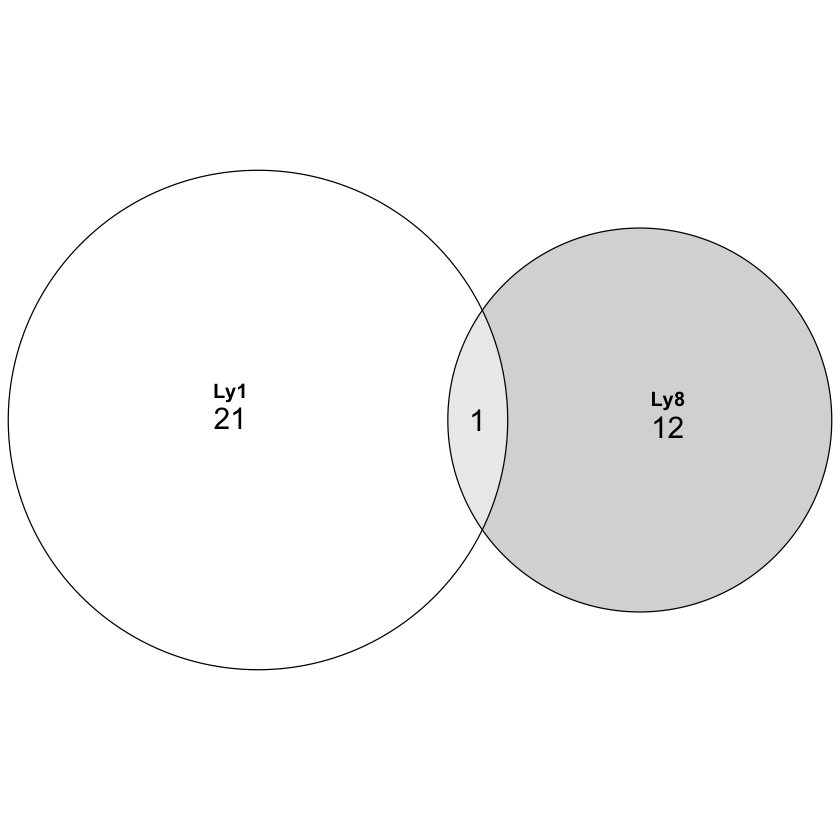

In [19]:
# plot overlap between Ly1 and Ly8 down
idx_down_ly1 <- genes_TF_sign_notFASreg$Ly1$log2FoldChange < -threshold_absLcf2
idx_down_ly8 <- genes_TF_sign_notFASreg$Ly8$log2FoldChange < -threshold_absLcf2
plot(euler(list(Ly1 = rownames(genes_TF_sign_notFASreg$Ly1[idx_down_ly1,])
               ,Ly8 = rownames(genes_TF_sign_notFASreg$Ly8[idx_down_ly8,])
               )
          )
    ,quantities = list(fontsize = 18)
    ,counts = T
    )

print(intersect(rownames(genes_TF_sign_notFASreg$Ly1[idx_down_ly1,])
               ,rownames(genes_TF_sign_notFASreg$Ly8[idx_down_ly8,])) )

In [20]:
pdf("FAS_coTF_down.pdf")
plot(euler(list(Ly1 = rownames(genes_TF_sign_notFASreg$Ly1[idx_down_ly1,])
               ,Ly8 = rownames(genes_TF_sign_notFASreg$Ly8[idx_down_ly8,])
               )
          )
    ,quantities = list(fontsize = 18)
    ,counts = T
    )
dev.off()

pdf 
  2

[1] "ZNF32"


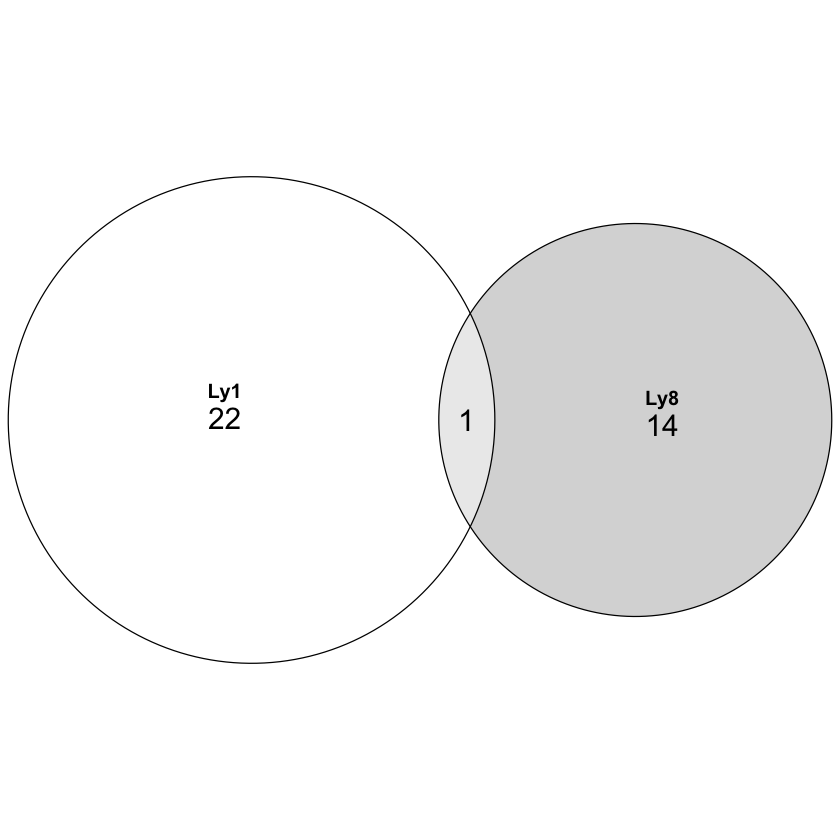

In [21]:
# plot overlap between Ly1 and Ly8 up
idx_up_ly1 <- genes_TF_sign_notFASreg$Ly1$log2FoldChange > threshold_absLcf2
idx_up_ly8 <- genes_TF_sign_notFASreg$Ly8$log2FoldChange > threshold_absLcf2
plot(euler(list(Ly1 = rownames(genes_TF_sign_notFASreg$Ly1[idx_up_ly1,])
               ,Ly8 = rownames(genes_TF_sign_notFASreg$Ly8[idx_up_ly8,]))
          )
    ,quantities = list(fontsize = 18)
    ,counts = T
    )

print(intersect(rownames(genes_TF_sign_notFASreg$Ly1[idx_up_ly1,])
               ,rownames(genes_TF_sign_notFASreg$Ly8[idx_up_ly8,])) )

In [22]:
pdf("FAS_coTF_up.pdf")
plot(euler(list(Ly1 = rownames(genes_TF_sign_notFASreg$Ly1[idx_up_ly1,])
               ,Ly8 = rownames(genes_TF_sign_notFASreg$Ly8[idx_up_ly8,])
               )
          )
    ,quantities = list(fontsize = 18)
    ,counts = T
    )
dev.off()

pdf 
  2

# Export

In [23]:
# Table of FAS regulating TFs with the information whether or not they are differential, and if yes, what is the direction
tableS3 <- cbind(cell_line = c(rep("OCI-Ly1"
                                  ,nrow(tf_fas_expressed$Ly1)
                                  )
                               ,rep("OCI-Ly8"
                                   ,nrow(tf_fas_expressed$Ly8)
                                   )
                              )
                 ,rbind(tf_fas_expressed$Ly1
                       ,tf_fas_expressed$Ly8)
                 ,isDiff = c(tf_fas_expressed$Ly1$tf %in% tf_fas_diff$Ly1$gene_name
                            ,tf_fas_expressed$Ly8$tf %in% tf_fas_diff$Ly8$gene_name)
                )
tableS3$pajd <- sapply(1:nrow(tableS3)
                           ,function(i){
                               if(tableS3$isDiff[i]){ # only for differential TFs
                                   idx_cell_line <- genes$cell_line == tableS3[i,"cell_line"]
                                   idx_tf <- genes$gene_name == tableS3$tf[i]
                                   genes[idx_cell_line & idx_tf,"padj"]
                               }else NA
                           })
tableS3$log2FC <- sapply(1:nrow(tableS3)
                           ,function(i){
                               if(tableS3$isDiff[i]){ # only for differential TFs
                                   idx_cell_line <- genes$cell_line == tableS3[i,"cell_line"]
                                   idx_tf <- genes$gene_name == tableS3$tf[i]
                                   genes[idx_cell_line & idx_tf,"log2FoldChange"]
                               }else NA
                           })
print(str(tableS3))

'data.frame':	54 obs. of  8 variables:
 $ cell_line : chr  "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" "OCI-Ly1" ...
 $ tf        : chr  "AEBP2" "ARID5A" "ARNTL2" "ETS1" ...
 $ confidence: chr  "E" "E" "E" "A" ...
 $ target    : chr  "FAS" "FAS" "FAS" "FAS" ...
 $ mor       : num  1 -1 1 1 1 -1 1 1 1 -1 ...
 $ isDiff    : logi  FALSE FALSE TRUE FALSE TRUE TRUE ...
 $ pajd      : num  NA NA 4.57e-06 NA 1.28e-06 ...
 $ log2FC    : num  NA NA -3.08 NA 1.96 ...
NULL


In [24]:
write.table(x = tableS3
          ,file = "TableS3_FAS_TF.txt"
          ,row.names = FALSE
          ,col.names = TRUE
          ,sep = "\t"
          ,quote = FALSE
         )

In [25]:
# Table of mutual expressed but not differential FAS regulating TFs and mutually differential potential co-TFs
mutually_expressed_nonDE_FAS_TF <- intersect(tf_fas_expressed_notDiff[["Ly1"]]$tf
                                             ,tf_fas_expressed_notDiff[["Ly8"]]$tf
                                            )
print(mutually_expressed_nonDE_FAS_TF)

mutually_down_coTF <- intersect(rownames(genes_TF_sign_notFASreg$Ly1[idx_down_ly1,])
                               ,rownames(genes_TF_sign_notFASreg$Ly8[idx_down_ly8,]))
print(mutually_down_coTF)

mutually_up_coTF <- intersect(rownames(genes_TF_sign_notFASreg$Ly1[idx_up_ly1,])
                               ,rownames(genes_TF_sign_notFASreg$Ly8[idx_up_ly8,]))
print(mutually_up_coTF)


tableS4 <- data.frame(tf = c(mutually_expressed_nonDE_FAS_TF
                            ,mutually_down_coTF
                            ,mutually_up_coTF)
                      ,type = c(rep("FAS_TF_non.de"
                                   ,length(mutually_expressed_nonDE_FAS_TF)
                                   )
                                ,rep("coTF_down"
                                    ,length(mutually_down_coTF)
                                    )
                                ,rep("coTF_up"
                                    ,length(mutually_up_coTF))
                               )
                     )
print(str(tableS4))

 [1] "AEBP2"  "ETS1"   "MYBL1"  "NFKB1"  "NFYC"   "PURA"   "SOX4"   "SP1"   
 [9] "SP100"  "SP110"  "SP140L" "STAT3"  "TP53"   "YBX1"   "YY1"    "ZBTB21"
[17] "ZNF136" "ZNF140" "ZNF267"
[1] "RUNX3"
[1] "ZNF32"
'data.frame':	21 obs. of  2 variables:
 $ tf  : chr  "AEBP2" "ETS1" "MYBL1" "NFKB1" ...
 $ type: chr  "FAS_TF_non.de" "FAS_TF_non.de" "FAS_TF_non.de" "FAS_TF_non.de" ...
NULL


In [26]:
write.table(x = tableS4
          ,file = "TableS4_FAS_coTF.txt"
          ,row.names = FALSE
          ,col.names = TRUE
          ,sep = "\t"
          ,quote = FALSE
         )

In [27]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] eulerr_6.1.1    dorothea_1.10.0

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.11       magrittr_2.0.3    tidyselect_1.2.0  uuid_1.1-0       
 [5] R6_2.5.1          rlang_1.1.1       fastmap_1.1.1     fansi_1.0.4      
 [9] polylabelr_0.2.0  bcellViper_1.34.0 dplyr_1.1.2       tools_4.2.2      
[13] grid_4.2.2        utf8_1.2.3        cli_3.6.1         htmltools_0.5.6  
[17] digest_0.6.33     tibble_3.2.1      lifecycle_1.0.3   crayon_1.5.2     
[21] IRdisplay_1.1     repr_1.1.4        base64enc_0.1-3   vctrs_0.6.3      
